# Hyperparameter Tuning with Image Clasification 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mohanen/noob_vision/blob/master/hyperparameter_tuning_tf.ipynb)

> we already know how to classify images from [cnn classification](https://colab.research.google.com/github/mohanen/noob_vision/blob/master/cnn_classification_tf.ipynb)

## Hyperparameter Tuning

> Choosing the set of optimal parameters from given choices

we can find the optimal parameters for all things, such as
1. No. of layers
2. No. of nodes on each layers
3. optimizer
4. learning rate
5. loss function
6. so on,..

But it takes more time as the combination increases, If you powerful processing environments you can try this to tune for optimal parameters

### Lets use the same steps as [cnn classification](https://colab.research.google.com/github/mohanen/noob_vision/blob/master/cnn_classification_tf.ipynb) with some overfit prevention mechanisms

1. Download and arrange dataset in file system
2. Load the training and valdiation data 
3. Create a CNN Model with HyperParameter Tuning
4. Train the model
5. Test the model


## Step 1: Download and arrange dataset in file systems

In [2]:
import tensorflow as tf
import numpy as np
import pathlib                  # For folder/file related operations
import matplotlib.pyplot as plt # For plotting graphs and showing images

# Reduce precission and speed thing up 60% on TPU and 3x on Modern GPU - optional
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Download the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# You don't need to seperate libraries to download and zip file, tensorflow itself has one built one, lets use that
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="the_dataset", extract=True, cache_dir="./")
# Pathlib allows you to do some path handling operations
data_dir = pathlib.Path(data_dir)
data_dir =  data_dir.parent.joinpath ('flower_photos')

# list the contents of data dir
# "!" indicated shell commands
!ls $data_dir

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


## Step 2: Load the training and validation data 


In [3]:
BATCH_SIZE = 32 # Instead of running all dataset one session its split into multiple batches for faster training and better convergence
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3 # RGB has 3 channels each represensting intensity of Red, Green, Blue 

# To load the image from directory we can use the tensorflow api itself
# training and validation split can also be configured with the same api
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,               # path to dataset
    validation_split=0.2,   # percent of data reserved for validation
    subset="training",      # training or validation subset
    seed=123,               # seed helps in shuffling images same way for both training and validation 
    image_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE   
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="validation", 
    seed=123, 
    image_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE)

# store the class names
class_names = train_ds.class_names

# Improves tensorflow performance drastically
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

print (class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Step 3: Hyperparameter tuning - Find optimal parameters for model

1. Since it involves training the model to find the best parameter, we can get the best model once done instead of training again.

2. Or you if the resource or time is not enought to tune with all dataset, you can use a random subset of the dataset and get optimal parameters and again train with full dataset for the best model which as best parameters and has good starting point values 

In [4]:
# install keras tuner if haven't already
!pip install -q -U keras-tuner


     |████████████████████████████████| 71kB 8.5MB/s 


In [5]:
from tensorflow.keras import layers, models
import kerastuner as kt

# The more options the more time it takes to find the best combination of optimal params
# So If you already know some good limits, it'll help you save some time
def model_builder(hp):
  inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  x = inputs
  for i in range(hp.Int('layers', 3, 4, step=1)):
    filters = hp.Int('fitlers_'+str(i), 64, 128, step=32)

    x = layers.Conv2D(filters=filters,
                      kernel_size=3,
                      padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      hp.Int('hidden_size', 128, 256, step=32),
      activation='relu'
  )(x)
  x = layers.Dropout(
      hp.Float('dropout', 0.2, 0.4, step=0.2, default=0.4)
  )(x)
  output = layers.Dense(len(class_names), activation='softmax')(x)

  model = tf.keras.Model(inputs, output)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=['accuracy']
  )

  return model

tuner = kt.Hyperband(model_builder,
                    objective='val_accuracy',
                    max_epochs=30,
                    hyperband_iterations=2)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print(best_hyperparameters)

model.summary()

Trial 180 Complete [00h 00m 43s]
val_accuracy: 0.6594005227088928

Best val_accuracy So Far: 0.7602179646492004
Total elapsed time: 01h 11m 09s
INFO:tensorflow:Oracle triggered exit
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (C

### Plot Confusion matrix for validation data

It gives an visual represention of how good the model is performing

Confusion matrix, without normalization


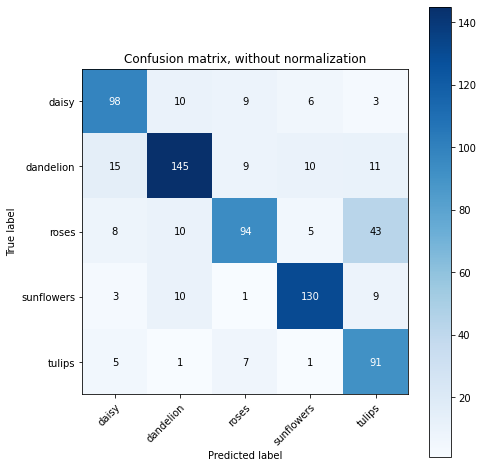

In [6]:
#Defining function for confusion matrix plot - https://analyticsindiamag.com/implementing-efficientnet-a-powerful-convolutional-neural-network/
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

val_ds_u = val_ds.unbatch()
val_ds_u = list(val_ds_u.as_numpy_iterator())
img_arr = np.array([image for image, label in val_ds_u])
lbl_arr = np.array([label for image, label in val_ds_u])

val_p = model.predict(img_arr)


val_r = [np.argmax(y) for y in val_p]

plot_confusion_matrix(val_r, lbl_arr, class_names)

## Step 5: Test the model


In [7]:
# Place an url of any new images and try the results 
image_url = "https://upload.wikimedia.org/wikipedia/commons/c/ce/Daisy_G%C3%A4nsebl%C3%BCmchen_Bellis_perennis_01.jpg"

# tf cahces the data to be dowloaded, so just make sure we clean if any previous image was already stored
!rm datasets/Image.png

# Download the image to local storage
image_path = tf.keras.utils.get_file('Image.png', origin=image_url, cache_dir="./")
# Load the image from local storage using tensorflow api's 
img = tf.keras.preprocessing.image.load_img(
    image_path, 
    target_size=(IMG_WIDTH, IMG_HEIGHT)
    )
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print("This definitely an {} - {}".format(class_names[np.argmax(score)], round(100 * np.max(score))))

rm: cannot remove 'datasets/Image.png': No such file or directory
1261568/1256730 [==============================] - 0s 0us/step
This definitely an daisy - 40
